# DEFAULT OF CREDIT NEURAL NETWORK

## IMPORTS (module)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

## IMPORTS (data)

In [2]:
df = pd.read_csv('datasets/UCI_Credit_Card.csv')

# Split into features (X) and target (y)
X = df.drop('default.payment.next.month', axis=1) 
y = df['default.payment.next.month']

# Split with 90% train, 10% test
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"Training set size: {len(X)}")
print(f"Test set size: {len(X_test)}")

# Reshape y pour avoir shape (1, n_samples)
y = y.values.reshape(1, -1)
y_test = y_test.values.reshape(1, -1)

# Reshape X pour avoir shape (n_features, n_samples) 
X = X.T 
X_test = X_test.T

print("X shape:", X.shape)
print("y shape:", y.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X.shape
y.shape
y_test.shape
X_test.shape

Training set size: 27000
Test set size: 3000
X shape: (24, 27000)
y shape: (1, 27000)
X_test shape: (24, 3000)
y_test shape: (1, 3000)


(24, 3000)

In [3]:
# Initialisation des parametres W et b et dimensions (Weight and biais)
def initialisation(dimensions):

    parametres = {}
    C = len(dimensions)

    for c in range (1, C):
        parametres['W' + str(c)] = np.random.randn(dimensions[c], dimensions[c - 1])
        parametres['b' + str(c)] = np.random.randn(dimensions[c], 1)

    return parametres

In [4]:
#  Z = x1 * w1 + x2 * w2 + b /// if Z > 0 alors y = 1 else y = 0 
#  A = sigmoide de Z

def forward_propagation(X, parametres):

    activations = {'A0' : X}

    C = len(parametres) // 2

    for c in range(1, C + 1):
        Z = parametres['W' + str(c)].dot(activations['A' + str(c - 1)]) + parametres['b' + str(c)]
        Z = np.clip(Z, -500, 500)
        activations['A' + str(c)] = 1 / (1 + np.exp(-Z))

    return activations

In [ ]:
# Descente de Gradient
def back_propagation(y, activations, parametres):

    m = y.shape[1]
    C = len(parametres) // 2

    dZ = activations['A' + str(C)] - y
    gradients = {}

    for c in reversed(range(1, C + 1)):
        gradients['dW' + str(c)] = 1 / m * np.dot(dZ, activations['A' + str(c - 1)].T)
        gradients['db' + str(c)] = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        if c > 1:
            dZ = np.dot(parametres['W' + str(c)].T, dZ) * activations['A' + str(c - 1)] * (1 - activations['A' + str(c - 1)])

    return gradients

In [6]:
def update(gradients, parametres, learning_rate):

    C = len(parametres) // 2

    for c in range(1, C + 1):
        parametres['W' + str(c)] = parametres['W' + str(c)] - learning_rate * gradients['dW' + str(c)]
        parametres['b' + str(c)] = parametres['b' + str(c)] - learning_rate * gradients['db' + str(c)]

    return parametres

In [7]:
def predict(X, parametres):
    activations = forward_propagation(X, parametres)
    C = len(parametres) // 2
    Af = activations['A' + str(C)]
    return Af >= 0.5

In [8]:
def evaluate_model(X, y, parametres):
    """
    Évalue les performances du modèle sur un jeu de données donné.
    """
    activations = forward_propagation(X, parametres)
    C = len(parametres) // 2
    
    # Calcul de la perte
    loss = log_loss(y.flatten(), activations['A' + str(C)].flatten())
    
    # Prédictions
    y_pred = predict(X, parametres)
    
    # Calcul de l'exactitude
    accuracy = accuracy_score(y.flatten(), y_pred.flatten())
    
    return loss, accuracy


def neural_network(X, y, X_test, y_test, hidden_layers=(32, 32, 32), learning_rate=0.1, n_iter=1000):
    np.random.seed(0)
    # Initialisation des paramètres W, b
    dimensions = list(hidden_layers)
    dimensions.insert(0, X.shape[0])  # Entrée
    dimensions.append(y.shape[0])    # Sortie
    parametres = initialisation(dimensions)

    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    for i in tqdm(range(n_iter)):
        activations = forward_propagation(X, parametres)
        gradients = back_propagation(y, activations, parametres)
        parametres = update(gradients, parametres, learning_rate)

        if i % 10 == 0:
            # Évaluation sur le train set
            C = len(parametres) // 2
            train_loss.append(log_loss(y.flatten(), activations['A' + str(C)].flatten()))
            y_pred = predict(X, parametres)
            train_accuracy.append(accuracy_score(y.flatten(), y_pred.flatten()))
            
            # Évaluation sur le test set
            loss, accuracy = evaluate_model(X_test, y_test, parametres)
            test_loss.append(loss)
            test_accuracy.append(accuracy)

    # Visualisation des résultats
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    ax[0].plot(train_loss, label='Train Loss')
    ax[0].plot(test_loss, label='Test Loss')
    ax[0].set_title('Loss')
    ax[0].legend()

    ax[1].plot(train_accuracy, label='Train Accuracy')
    ax[1].plot(test_accuracy, label='Test Accuracy')
    ax[1].set_title('Accuracy')
    ax[1].legend()

    plt.show()

    # Afficher les performances finales sur le test set
    final_test_loss, final_test_accuracy = evaluate_model(X_test, y_test, parametres)
    print(f"Final Test Loss: {final_test_loss}")
    print(f"Final Test Accuracy: {final_test_accuracy}")

    print("\nSchema du Neural Network :")
    print("Parametre d'entrée :")
    print(parametres['W1'].shape[1])
    l = 1
    for i in hidden_layers:
        print('Neurone dans la Couche', l, ': ') 
        print(i)
        l += 1
    print("sortie :")
    print(parametres['b' + str(l)].shape[1])
        
    print("\nEntrainement :")
    print("Nombre d'itteration :", n_iter)
    print("taille des pas: ", learning_rate)
    print("\n \n")


    return parametres

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:35<00:00, 28.41it/s]


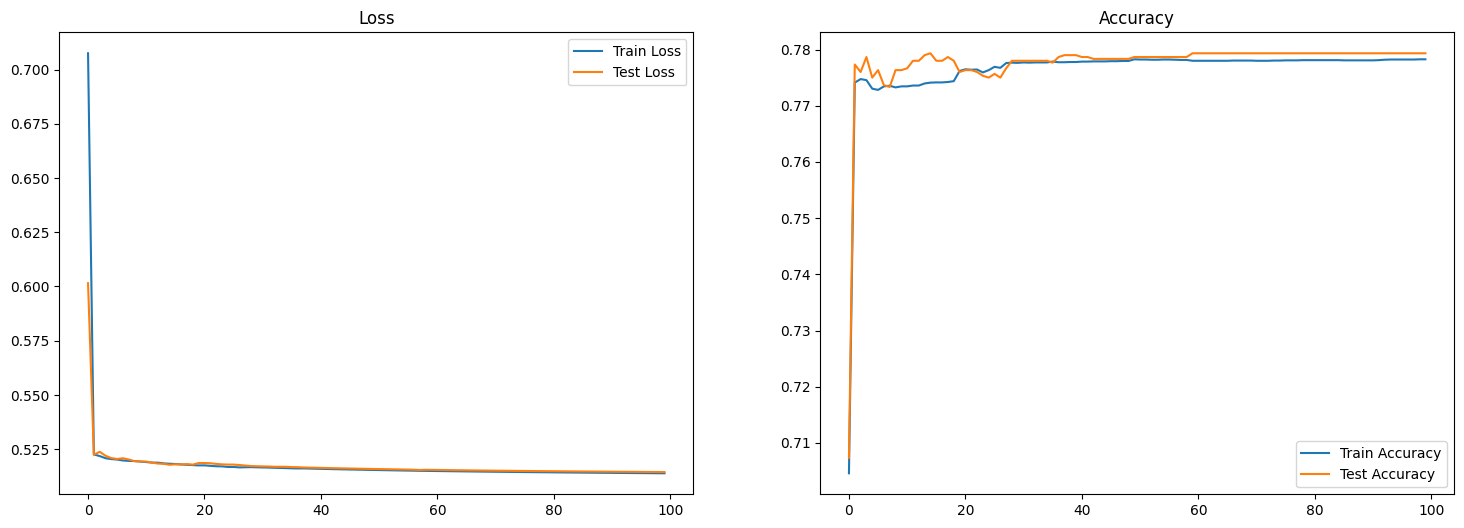

Final Test Loss: 0.5144521518611073
Final Test Accuracy: 0.7793333333333333

Schema du Neural Network :
Parametre d'entrée :
24
Neurone dans la Couche 1 : 
32
Neurone dans la Couche 2 : 
32
Neurone dans la Couche 3 : 
32
sortie :
1

Entrainement :
Nombre d'itteration : 1000
taille des pas:  0.1

 



100%|██████████| 10000/10000 [07:50<00:00, 21.27it/s]


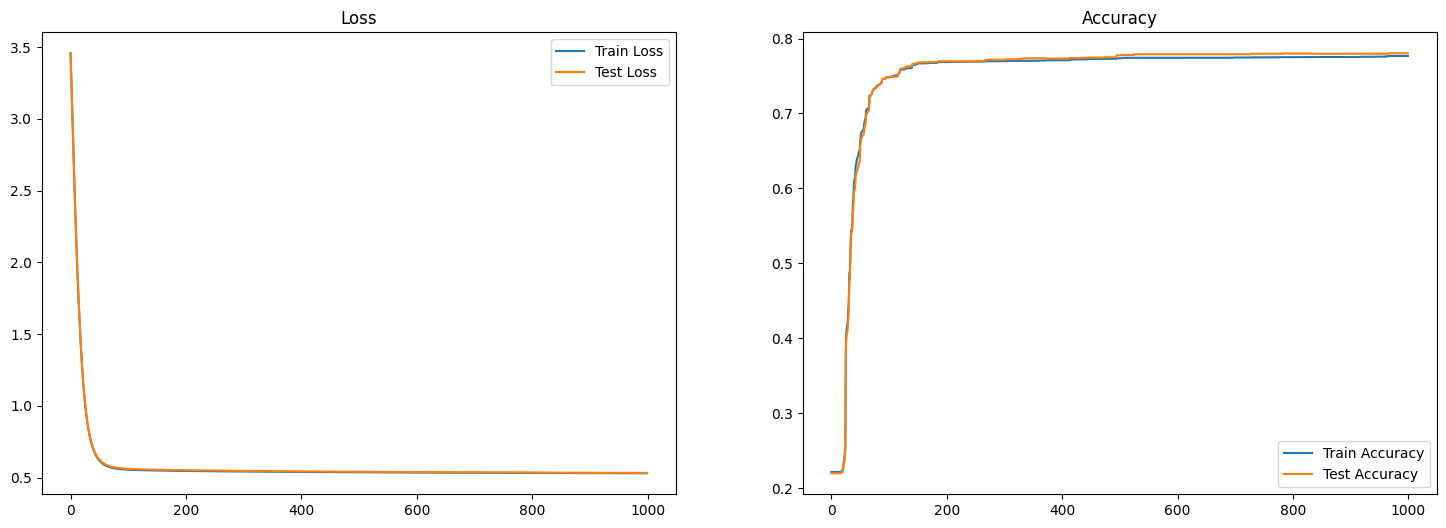

Final Test Loss: 0.53333980705692
Final Test Accuracy: 0.7803333333333333

Schema du Neural Network :
Parametre d'entrée :
24
Neurone dans la Couche 1 : 
32
Neurone dans la Couche 2 : 
32
Neurone dans la Couche 3 : 
32
Neurone dans la Couche 4 : 
32
sortie :
1

Entrainement :
Nombre d'itteration : 10000
taille des pas:  0.001

 



100%|██████████| 10000/10000 [11:27<00:00, 14.55it/s]


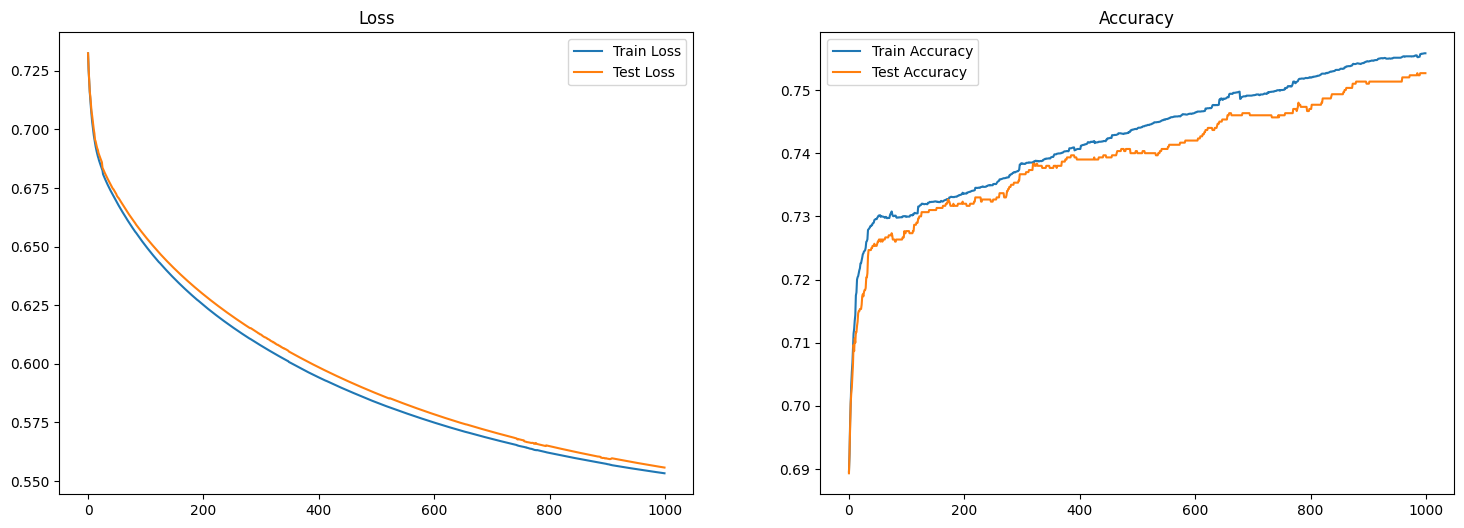

Final Test Loss: 0.5557028147908898
Final Test Accuracy: 0.7526666666666667

Schema du Neural Network :
Parametre d'entrée :
24
Neurone dans la Couche 1 : 
64
Neurone dans la Couche 2 : 
64
Neurone dans la Couche 3 : 
64
sortie :
1

Entrainement :
Nombre d'itteration : 10000
taille des pas:  0.001

 



In [9]:
parametres = neural_network(X, y, X_test, y_test, hidden_layers = (32, 32, 32), learning_rate = 0.1, n_iter =1000)
parametres = neural_network(X, y, X_test, y_test, hidden_layers = (32, 32, 32, 32), learning_rate = 0.001, n_iter =10000)
parametres = neural_network(X, y, X_test, y_test, hidden_layers = (64, 64, 64), learning_rate = 0.001, n_iter =10000)

100%|██████████| 10000/10000 [11:28<00:00, 14.52it/s]


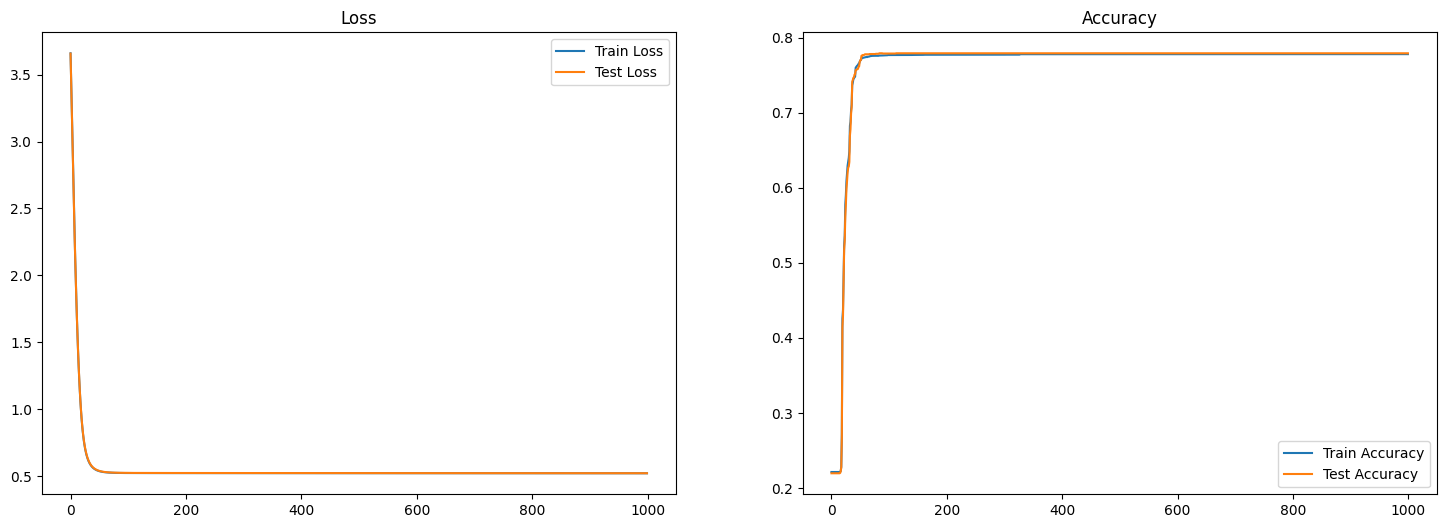

Final Test Loss: 0.5225685867626385
Final Test Accuracy: 0.779

Schema du Neural Network :
Parametre d'entrée :
24
Neurone dans la Couche 1 : 
32
Neurone dans la Couche 2 : 
32
Neurone dans la Couche 3 : 
32
Neurone dans la Couche 4 : 
32
Neurone dans la Couche 5 : 
32
Neurone dans la Couche 6 : 
32
sortie :
1

Entrainement :
Nombre d'itteration : 10000
taille des pas:  0.001

 



In [11]:
parametres = neural_network(X, y, X_test, y_test, hidden_layers = (32, 32, 32, 32, 32, 32), learning_rate = 0.001, n_iter =10000)

# BEST MODEL is N.2 
## parametres = neural_network(X, y, X_test, y_test, hidden_layers = (32, 32, 32, 32), learning_rate = 0.001, n_iter =10000)

Final Test Loss: 0.53333980705692
Final Test Accuracy: 0.7803333333333333

Schema du Neural Network :
Parametre d'entrée :
24
Neurone dans la Couche 1 : 
32
Neurone dans la Couche 2 : 
32
Neurone dans la Couche 3 : 
32
Neurone dans la Couche 4 : 
32
sortie :
1

Entrainement :
Nombre d'itteration : 10000
taille des pas:  0.001


### Le model est relativement rapide a entrainer 11:27, pour un precision sur le test set de 78 %


